# Transformer-based Structural Health Monitoring System
This notebook replicates the functionality of the LSTM-based SHM system using a Transformer model, including defect detection, residual analysis, AUC/MSE scoring, and visualization.

Epoch 1/20
226/226 [==============================] - 22s 92ms/step - loss: 0.1948
Epoch 2/20
226/226 [==============================] - 21s 94ms/step - loss: 0.0134
Epoch 3/20
226/226 [==============================] - 22s 96ms/step - loss: 0.0134
Epoch 4/20
226/226 [==============================] - 24s 104ms/step - loss: 0.0057
Epoch 5/20
226/226 [==============================] - 25s 109ms/step - loss: 0.0038
Epoch 6/20
226/226 [==============================] - 26s 113ms/step - loss: 0.0037
Epoch 7/20
226/226 [==============================] - 26s 114ms/step - loss: 0.0037
Epoch 8/20
226/226 [==============================] - 25s 112ms/step - loss: 0.0037
Epoch 9/20
226/226 [==============================] - 25s 111ms/step - loss: 0.0035
Epoch 10/20
226/226 [==============================] - 26s 116ms/step - loss: 0.0037
Epoch 11/20
226/226 [==============================] - 27s 118ms/step - loss: 0.0036
Epoch 12/20
226/226 [==============================] - 26s 116ms/step - loss:

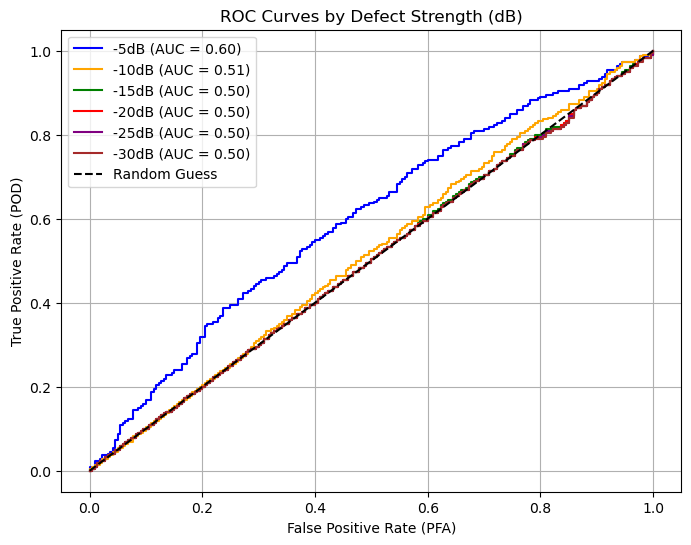

In [3]:
# First version of the simple model

import numpy as np
import scipy.io
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

n_h = 80
OUT_STEPS = 20

def generate_lstm_training_data(signals, window_size, out_steps):
    samples, targets = [], []
    for sig in signals:
        for i in range(len(sig) - window_size - out_steps + 1):
            x = sig[i:i+window_size]
            y = sig[i+window_size+out_steps-1]
            samples.append(x)
            targets.append(y)
    return np.array(samples).reshape(-1, window_size, 1), np.array(targets).reshape(-1, 1)

def build_forecast_model(n_h=80, hidden_units=128):
    inputs = tf.keras.Input(shape=(n_h, 1))
    x = tf.keras.layers.Conv1D(16, 5, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(1, 5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Dense(hidden_units)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    attn = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=hidden_units//4)(x, x)
    x = tf.keras.layers.Add()([x, attn])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=output)

def TestDetectionTransformer(model):
    def prepare(signal):
        return generate_lstm_training_data(signal, window_size=n_h, out_steps=OUT_STEPS)

    def residual_analysis(signal):
        x_t, y_t = prepare(signal)
        preds = model.predict(x_t)
        residuals = y_t.flatten() - preds.flatten()
        residuals -= np.mean(residuals)
        return np.abs(residuals)

    x_base, y_base = prepare(baseline)
    preds_base = model.predict(x_base)
    df_residual = y_base.flatten() - preds_base.flatten()
    df_residual -= np.mean(df_residual)
    df_residual = np.abs(df_residual)

    residuals = [residual_analysis(d) for d in [defect_5db, defect_10db, defect_15db, defect_20db, defect_25db, defect_30db]]

    def reshape_residual(r):
        return r[-error_len * test_size:].reshape(error_len, test_size)

    r_base = reshape_residual(df_residual)
    r_def = [reshape_residual(r) for r in residuals]

    max_base = np.max(r_base, axis=0)
    scores = [np.max(r, axis=0) for r in r_def]
    label0 = np.zeros_like(max_base)
    label1 = np.ones_like(scores[0])
    label = np.concatenate([label0, label1])

    aucs, pfas, pods = [], [], []
    for s in scores:
        s_all = np.concatenate([max_base, s])
        fpr, tpr, _ = roc_curve(label, s_all)
        aucs.append(auc(fpr, tpr))
        pfas.append(fpr)
        pods.append(tpr)

    test_mse = np.mean(np.square(df_residual))
    print(f"Test MSE: {test_mse:.6f}")
    for i, a in enumerate(aucs):
        print(f"AUC d{i+1}: {a:.8f}")
    return aucs, pfas, pods, test_mse

def plot_roc_curves(pfas, pods, aucs):
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    labels = ["-5dB", "-10dB", "-15dB", "-20dB", "-25dB", "-30dB"]
    for i in range(len(pfas)):
        plt.plot(pfas[i], pods[i], label=f"{labels[i]} (AUC = {aucs[i]:.2f})", color=colors[i])
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate (PFA)")
    plt.ylabel("True Positive Rate (POD)")
    plt.title("ROC Curves by Defect Strength (dB)")
    plt.grid(True)
    plt.legend()
    plt.show()

train_mat = scipy.io.loadmat("train_normalised.mat")
train_data = np.array(train_mat['test_normalised'])

x_train, y_train = generate_lstm_training_data(train_data, window_size=n_h, out_steps=OUT_STEPS)

model = build_forecast_model(n_h=n_h)
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, batch_size=512, epochs=20)

baseline = np.array(scipy.io.loadmat("test_normalised.mat")['test_normalised'])
defect_5db = np.array(scipy.io.loadmat("test_defect_-5db.mat")['test_defect'])
defect_10db = np.array(scipy.io.loadmat("test_defect_-10db.mat")['test_defect'])
defect_15db = np.array(scipy.io.loadmat("test_defect_-15db.mat")['test_defect'])
defect_20db = np.array(scipy.io.loadmat("test_defect_-20db.mat")['test_defect'])
defect_25db = np.array(scipy.io.loadmat("test_defect_-25db.mat")['test_defect'])
defect_30db = np.array(scipy.io.loadmat("test_defect_-30db.mat")['test_defect'])

error_len = 50
test_size = defect_5db.shape[0]

aucs, pfas, pods, test_mse = TestDetectionTransformer(model)
plot_roc_curves(pfas, pods, aucs)


Epoch 1/20
226/226 [==============================] - 21s 90ms/step - loss: 0.0399
Epoch 2/20
226/226 [==============================] - 22s 95ms/step - loss: 0.0130
Epoch 3/20
226/226 [==============================] - 22s 95ms/step - loss: 0.0128
Epoch 4/20
226/226 [==============================] - 22s 96ms/step - loss: 0.0127
Epoch 5/20
226/226 [==============================] - 22s 95ms/step - loss: 0.0126
Epoch 6/20
226/226 [==============================] - 22s 97ms/step - loss: 0.0124
Epoch 7/20
226/226 [==============================] - 22s 95ms/step - loss: 0.0124
Epoch 8/20
226/226 [==============================] - 22s 95ms/step - loss: 0.0122
Epoch 9/20
226/226 [==============================] - 22s 95ms/step - loss: 0.0121
Epoch 10/20
226/226 [==============================] - 22s 96ms/step - loss: 0.0119
Epoch 11/20
226/226 [==============================] - 22s 95ms/step - loss: 0.0119
Epoch 12/20
226/226 [==============================] - 22s 96ms/step - loss: 0.0118
E

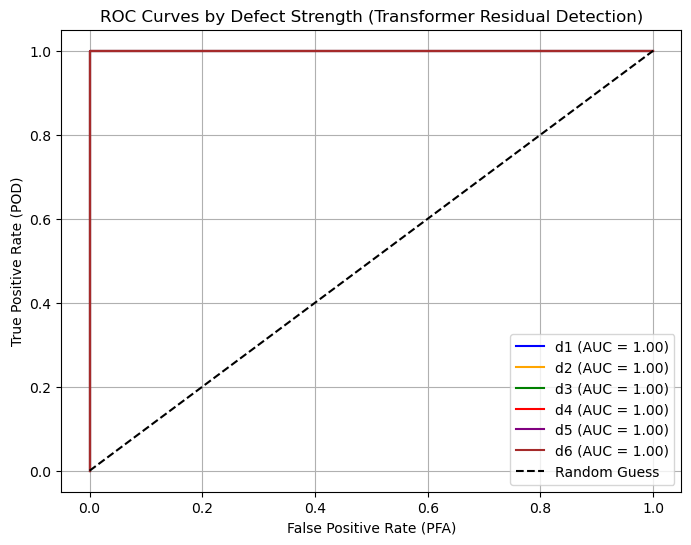


Test MSE on baseline: 0.011164
Transformer Residual Detection AUCs:
Defect d1: AUC = 1.0000
Defect d2: AUC = 1.0000
Defect d3: AUC = 1.0000
Defect d4: AUC = 1.0000
Defect d5: AUC = 1.0000
Defect d6: AUC = 1.0000


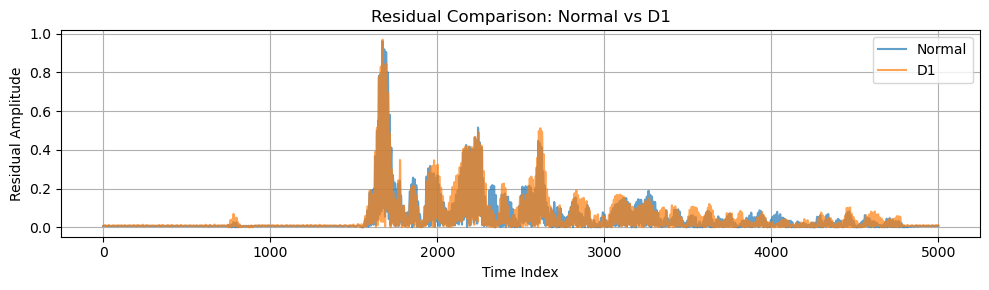

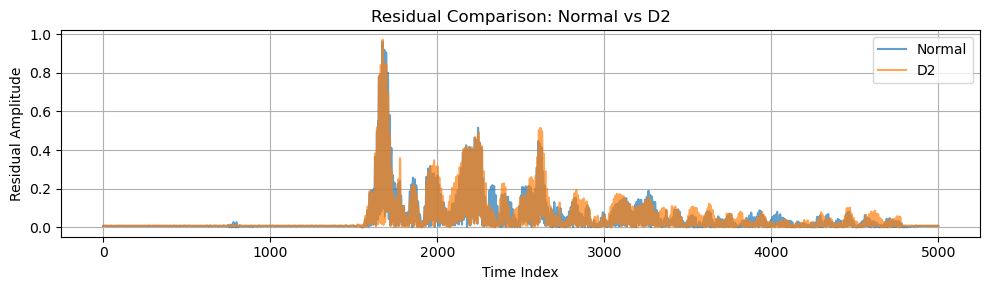

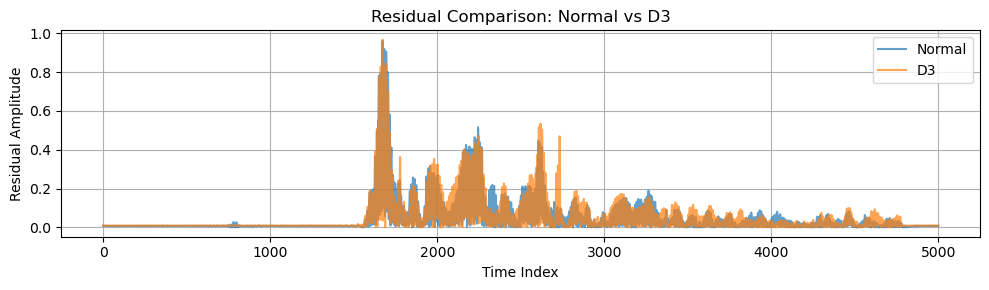

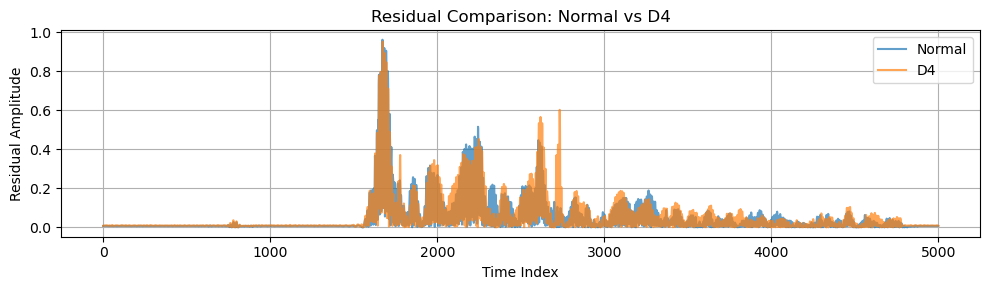

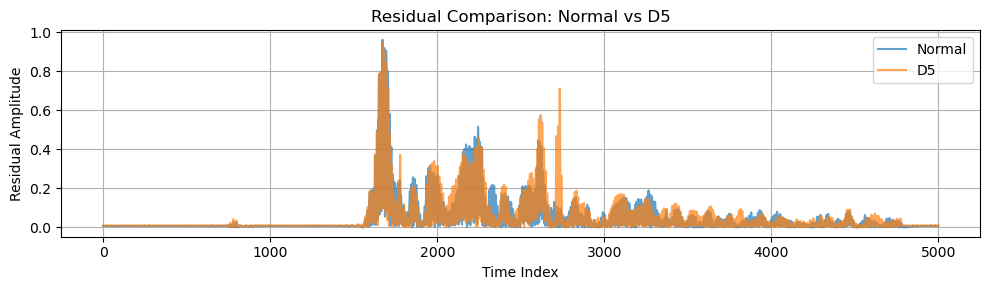

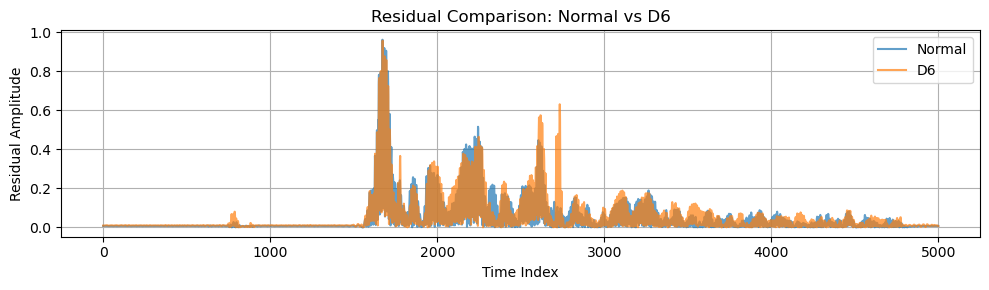

In [4]:
# Detection of real defects

import numpy as np
import scipy.io
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

window_size = 80
forecast_horizon = 20

def normalize_by_sample(signal):
    return signal / np.max(np.abs(signal), axis=1, keepdims=True)

def generate_transformer_training_data(signals, window_size, out_steps):
    samples, targets = [], []
    for sig in signals:
        for i in range(len(sig) - window_size - out_steps + 1):
            x = sig[i:i+window_size]
            y = sig[i+window_size+out_steps-1]
            samples.append(x)
            targets.append(y)
    return np.array(samples).reshape(-1, window_size, 1), np.array(targets).reshape(-1, 1)

def build_transformer_model(window_size, d_model=64, num_heads=4, ff_dim=128):
    inputs = tf.keras.Input(shape=(window_size, 1))
    x = tf.keras.layers.Dense(d_model)(inputs)
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    x_ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    x_ffn = tf.keras.layers.Dense(d_model)(x_ffn)
    x = tf.keras.layers.Add()([x, x_ffn])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=output)

train_mat = scipy.io.loadmat("train_normalised.mat")
train_data = np.array(train_mat['test_normalised'])
train_data = normalize_by_sample(train_data)

x_train, y_train = generate_transformer_training_data(train_data, window_size, forecast_horizon)

model = build_transformer_model(window_size)
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=1)

# === Step 4: Load and Normalize Test Sets ===
baseline = np.array(scipy.io.loadmat("test_normalised.mat")['test_normalised'])
defect_1 = normalize_by_sample(np.array(scipy.io.loadmat("test_defect1.mat")['test_defect1']))
defect_2 = normalize_by_sample(np.array(scipy.io.loadmat("test_defect2.mat")['test_defect2']))
defect_3 = normalize_by_sample(np.array(scipy.io.loadmat("test_defect3.mat")['test_defect3']))
defect_4 = normalize_by_sample(np.array(scipy.io.loadmat("test_defect4.mat")['test_defect4']))
defect_5 = normalize_by_sample(np.array(scipy.io.loadmat("test_defect5.mat")['test_defect5']))
defect_6 = normalize_by_sample(np.array(scipy.io.loadmat("test_defect6.mat")['test_defect6']))

def compute_residual(signal, model):
    x_t, y_t = generate_transformer_training_data(signal, window_size, forecast_horizon)
    preds = model.predict(x_t, batch_size=512)
    residuals = y_t.flatten() - preds.flatten()
    mse = np.mean(np.square(residuals))
    residuals -= np.mean(residuals)
    return np.abs(residuals), mse, preds.flatten(), y_t.flatten()

def reshape_residual(r, error_len, test_size):
    return r[-error_len * test_size:].reshape(error_len, test_size)

error_len = 50
test_size = defect_1.shape[0]

r_base_raw, test_mse, base_pred, base_true = compute_residual(baseline, model)
r_base = reshape_residual(r_base_raw, error_len, test_size)

r_defects = []
all_residual_raw = []
for defect in [defect_1, defect_2, defect_3, defect_4, defect_5, defect_6]:
    r_raw, _, _, _ = compute_residual(defect, model)
    all_residual_raw.append(r_raw)
    r_defects.append(reshape_residual(r_raw, error_len, test_size))

max_base = np.max(r_base, axis=0)

scores = [np.mean(r, axis=0) + np.std(r, axis=0) for r in r_defects]
label0 = np.zeros_like(max_base)
label1 = np.ones_like(scores[0])
label = np.concatenate([label0, label1])

pfas, pods, aucs = [], [], []
for s in scores:
    s_all = np.concatenate([max_base, s])
    fpr, tpr, _ = roc_curve(label, s_all)
    pfas.append(fpr)
    pods.append(tpr)
    aucs.append(auc(fpr, tpr))

def plot_roc_curves(pfas, pods, aucs):
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    labels = ["d1", "d2", "d3", "d4", "d5", "d6"]
    for i in range(len(pfas)):
        plt.plot(pfas[i], pods[i], label=f"{labels[i]} (AUC = {aucs[i]:.2f})", color=colors[i])
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate (PFA)")
    plt.ylabel("True Positive Rate (POD)")
    plt.title("ROC Curves by Defect Strength (Transformer Residual Detection)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_roc_curves(pfas, pods, aucs)

print(f"\nTest MSE on baseline: {test_mse:.6f}")
print("Transformer Residual Detection AUCs:")
for i, a in enumerate(aucs):
    print(f"Defect d{i+1}: AUC = {a:.4f}")

def plot_residual_comparison(r_base, all_r_defects):
    for i, r in enumerate(all_r_defects):
        plt.figure(figsize=(10, 3))
        plt.plot(r_base_raw[:5000], label="Normal", alpha=0.7)
        plt.plot(r[:5000], label=f"D{i+1}", alpha=0.7)
        plt.title(f"Residual Comparison: Normal vs D{i+1}")
        plt.xlabel("Time Index")
        plt.ylabel("Residual Amplitude")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_residual_comparison(r_base_raw, all_residual_raw)


In [5]:
import numpy as np
import scipy.io
import os

def add_noise(signal, snr_db):
    power = np.mean(signal**2)
    noise_power = power / (10**(snr_db/10))
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

def normalize_by_sample(signal):
    max_per_signal = np.max(np.abs(signal), axis=1, keepdims=True)
    return signal / max_per_signal

def generate_noisy_baseline(input_file='test_normalised.mat', output_file='test_noisy_normalised.mat', snr_range=(10, 30)):
    print(f"Loading {input_file}...")
    data = scipy.io.loadmat(input_file)
    clean = data['test_normalised']
    
    num_signals, signal_length = clean.shape
    noisy = np.zeros_like(clean)
    
    print(f"Adding random Gaussian noise with SNR in {snr_range} dB range...")
    for i in range(num_signals):
        snr_db = np.random.uniform(*snr_range)
        noisy[i, :] = add_noise(clean[i, :], snr_db)
    
    print("Normalizing each signal...")
    noisy_normalized = normalize_by_sample(noisy)
    
    print(f"Saving to {output_file}...")
    scipy.io.savemat(output_file, {'noisy_normalised': noisy_normalized})
    
    print("Done: noisy baseline generated and saved.")

if __name__ == "__main__":
    generate_noisy_baseline()


Loading test_normalised.mat...
Adding random Gaussian noise with SNR in (10, 30) dB range...
Normalizing each signal...
Saving to test_noisy_normalised.mat...
Done: noisy baseline generated and saved.



>>> Loading clean training data...

>>> Pretraining on clean + noise-augmented data...
Epoch 1/20
226/226 [==============================] - 21s 88ms/step - loss: 0.0050
Epoch 2/20
226/226 [==============================] - 20s 90ms/step - loss: 0.0035
Epoch 3/20
226/226 [==============================] - 20s 90ms/step - loss: 0.0028
Epoch 4/20
226/226 [==============================] - 21s 92ms/step - loss: 0.0025
Epoch 5/20
226/226 [==============================] - 21s 92ms/step - loss: 0.0023
Epoch 6/20
226/226 [==============================] - 20s 90ms/step - loss: 0.0021
Epoch 7/20
226/226 [==============================] - 20s 90ms/step - loss: 0.0019
Epoch 8/20
226/226 [==============================] - 20s 90ms/step - loss: 0.0018
Epoch 9/20
226/226 [==============================] - 20s 90ms/step - loss: 0.0016
Epoch 10/20
226/226 [==============================] - 21s 91ms/step - loss: 0.0015
Epoch 11/20
226/226 [==============================] - 20s 90ms/step - loss: 0.00

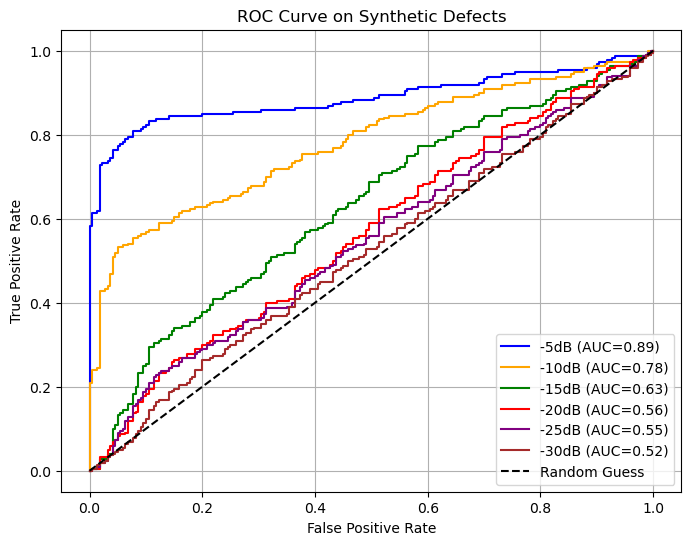

Synthetic defect AUCs:
Defect 5dB: AUC = 0.8873
Defect 10dB: AUC = 0.7789
Defect 15dB: AUC = 0.6267
Defect 20dB: AUC = 0.5649
Defect 25dB: AUC = 0.5481
Defect 30dB: AUC = 0.5194

All done.


In [6]:
# Second version adds noise fine-tuning

import numpy as np
import scipy.io
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

window_size = 80
forecast_horizon = 20
batch_size = 512
epochs_pretrain = 20
epochs_finetune = 10
error_len = 50

save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

def add_noise(signal, snr_db):
    power = np.mean(signal**2)
    noise_power = power / (10**(snr_db/10))
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

def generate_data(signals, window_size, out_steps, augment=False):
    X, Y = [], []
    for sig in signals:
        if augment:
            sig = add_noise(sig, np.random.uniform(5, 30))
        for i in range(len(sig) - window_size - out_steps + 1):
            x = sig[i:i+window_size]
            y = sig[i+window_size+out_steps-1]
            X.append(x)
            Y.append(y)
    return np.array(X).reshape(-1, window_size, 1), np.array(Y).reshape(-1, 1)

def build_transformer_model(window_size, d_model=64, num_heads=4, ff_dim=128):
    inputs = tf.keras.Input(shape=(window_size, 1))
    x = tf.keras.layers.Dense(d_model)(inputs)
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    ff_output = tf.keras.layers.Dense(d_model)(ff_output)
    x = tf.keras.layers.Add()([x, ff_output])
    x = tf.keras.layers.LayerNormalization()(x)
    res_attn = tf.keras.layers.GlobalAveragePooling1D()(x)
    res_attn = tf.keras.layers.Dense(window_size, activation='sigmoid')(res_attn)
    rescale = tf.keras.layers.Reshape((window_size, 1))(res_attn)
    x = tf.keras.layers.Multiply()([inputs, rescale])
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

print("\n>>> Loading clean training data...")
train_data = np.array(scipy.io.loadmat("train_normalised.mat")['test_normalised'])
x_train, y_train = generate_data(train_data, window_size, forecast_horizon, augment=True)

model = build_transformer_model(window_size)
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

print("\n>>> Pretraining on clean + noise-augmented data...")
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs_pretrain, verbose=1)

print("\n>>> Fine-tuning on real noisy baseline...")
fine_data = np.array(scipy.io.loadmat("test_noisy_normalised.mat")['noisy_normalised'])
x_fine, y_fine = generate_data(fine_data, window_size, forecast_horizon)
model.fit(x_fine, y_fine, batch_size=batch_size, epochs=epochs_finetune, verbose=1)

model.save(os.path.join(save_dir, "transformer_finetuned.h5"))
print("Model saved.\n")

def compute_residual(signal, model):
    x_t, y_t = generate_data(signal, window_size, forecast_horizon)
    preds = model.predict(x_t, batch_size=512)
    residuals = np.abs(y_t.flatten() - preds.flatten())
    residuals -= np.mean(residuals)
    return residuals

def reshape_residual(r, error_len, test_size):
    return r[-error_len * test_size:].reshape(error_len, test_size)

print("\n>>> Loading synthetic defects...")
baseline = np.array(scipy.io.loadmat("test_normalised.mat")['test_normalised'])
defect_files = ["test_defect_-5db.mat", "test_defect_-10db.mat", "test_defect_-15db.mat", "test_defect_-20db.mat", "test_defect_-25db.mat", "test_defect_-30db.mat"]
defect_signals = [np.array(scipy.io.loadmat(f)['test_defect']) for f in defect_files]

print("\n>>> Evaluating synthetic defects...")
error_len = 50
test_size = defect_signals[0].shape[0]

r_base = reshape_residual(compute_residual(baseline, model), error_len, test_size)
r_defects = [reshape_residual(compute_residual(d, model), error_len, test_size) for d in defect_signals]

max_base = np.max(r_base, axis=0)
scores = [np.max(r, axis=0) for r in r_defects]
label0 = np.zeros_like(max_base)
label1 = np.ones_like(scores[0])
label = np.concatenate([label0, label1])

pfas, pods, aucs = [], [], []
for s in scores:
    s_all = np.concatenate([max_base, s])
    fpr, tpr, _ = roc_curve(label, s_all)
    pfas.append(fpr)
    pods.append(tpr)
    aucs.append(auc(fpr, tpr))

def plot_roc(pfas, pods, aucs, title):
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    labels = ["-5dB", "-10dB", "-15dB", "-20dB", "-25dB", "-30dB"]
    for i in range(len(pfas)):
        plt.plot(pfas[i], pods[i], label=f"{labels[i]} (AUC={aucs[i]:.2f})", color=colors[i])
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(save_dir, f"{title.replace(' ', '_')}.png"))
    plt.show()

plot_roc(pfas, pods, aucs, "ROC Curve on Synthetic Defects")

print("Synthetic defect AUCs:")
for i, a in enumerate(aucs):
    print(f"Defect {5 + i*5}dB: AUC = {a:.4f}")

print("\nAll done.")

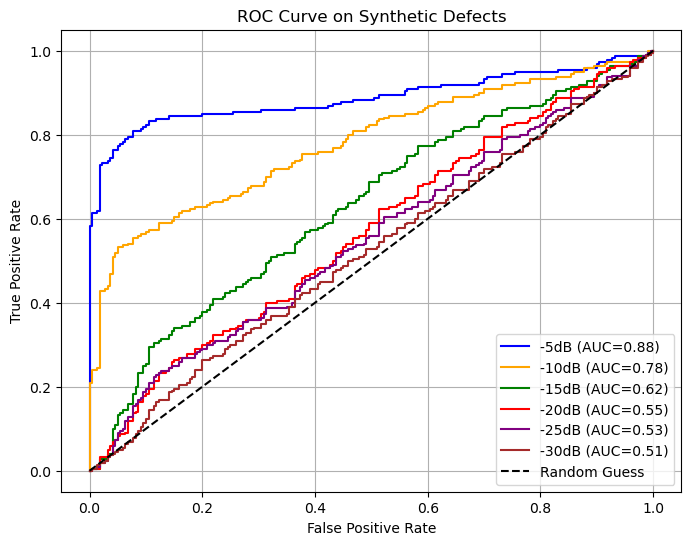

In [7]:
# Save ROC
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
labels = ["-5dB", "-10dB", "-15dB", "-20dB", "-25dB", "-30dB"]
aucs = [0.88, 0.78, 0.62, 0.55, 0.53, 0.51]

for i in range(len(pfas)):
    plt.plot(pfas[i], pods[i], label=f"{labels[i]} (AUC={aucs[i]:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Synthetic Defects")
plt.grid(True)
plt.legend()

plt.savefig("ROC_synthetic_defects.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\lyjco\.conda\envs\dts\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\lyjco\.conda\envs\dts\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\lyjco\.conda\envs\dts\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(
C:\Users\lyjco\.conda\envs\dts\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occur

Epoch 020 | Loss: 0.7799 | AUC: 0.6001 | MSC: 0.0041
Epoch 040 | Loss: 0.6606 | AUC: 0.5902 | MSC: 0.0072
Epoch 060 | Loss: 0.6735 | AUC: 0.5910 | MSC: 0.0007
Epoch 080 | Loss: 0.5209 | AUC: 0.5979 | MSC: 0.0000
Epoch 100 | Loss: 0.4602 | AUC: 0.6009 | MSC: 0.0012
Epoch 120 | Loss: 0.4795 | AUC: 0.6149 | MSC: 0.0146
Epoch 140 | Loss: 0.4261 | AUC: 0.6321 | MSC: 0.0121
Epoch 160 | Loss: 0.3977 | AUC: 0.6442 | MSC: 0.0139
Epoch 180 | Loss: 0.3212 | AUC: 0.6037 | MSC: 0.0007
Epoch 200 | Loss: 0.3620 | AUC: 0.5952 | MSC: 0.0061


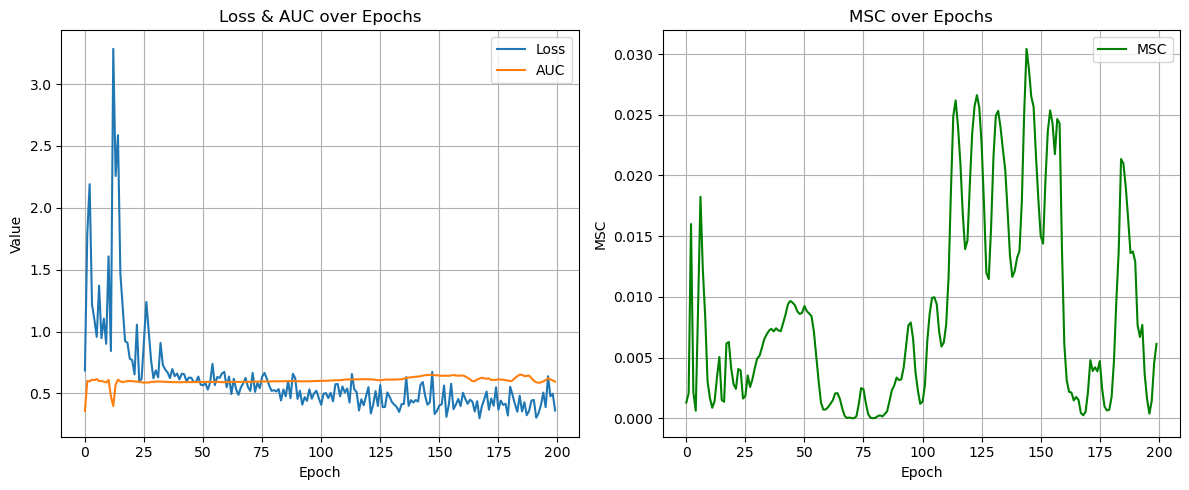

In [2]:
# Attempting a binary classification task

import scipy.io
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import TransformerConv

# Step 1: Load Data
train_data = scipy.io.loadmat('train_normalised.mat')
test_data = scipy.io.loadmat('test_normalised.mat')

X_train = train_data['test_normalised']
X_test = test_data['test_normalised']

y_train = np.array([0]*10 + [1]*10)
y_test = np.array([0]*110 + [1]*110)

X = np.vstack([X_train, X_test])
y = np.concatenate([y_train, y_test])

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# Build Graph using Cosine Similarity
cos_sim = cosine_similarity(X)
k = 5
adj_matrix = np.zeros_like(cos_sim)
for i in range(cos_sim.shape[0]):
    top_k = np.argsort(cos_sim[i])[-(k+1):-1]
    adj_matrix[i, top_k] = 1

edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# Train/Test Masks
num_train = X_train.shape[0]
train_mask = torch.zeros(X.shape[0], dtype=torch.bool)
test_mask = torch.zeros(X.shape[0], dtype=torch.bool)
train_mask[:num_train] = True
test_mask[num_train:] = True

# Create PyG Data Object
data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor,
            train_mask=train_mask, test_mask=test_mask)

# Define Transformer Model
class GraphTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.4):
        super(GraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels // heads, heads=heads, dropout=dropout)
        self.conv2 = TransformerConv(hidden_channels, out_channels, heads=1, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Initialize Transformer Model
model = GraphTransformer(in_channels=X.shape[1], hidden_channels=64, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

# Train and Evaluate Functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    preds = torch.exp(out[data.test_mask])[:, 1].detach().numpy()
    true = data.y[data.test_mask].detach().numpy()
    auc = roc_auc_score(true, preds)
    msc = np.corrcoef(true, preds)[0, 1] ** 2
    return auc, msc

# Train Loop
losses, aucs, mscs = [], [], []
for epoch in range(1, 201):
    loss = train()
    auc, msc = evaluate()
    losses.append(loss)
    aucs.append(auc)
    mscs.append(msc)
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | AUC: {auc:.4f} | MSC: {msc:.4f}")

# Plot Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.plot(aucs, label="AUC")
plt.title("Loss & AUC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mscs, label="MSC", color='green')
plt.title("MSC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSC")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()